# Data Mining

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import os
import pandas as pd
from scipy import stats
%matplotlib inline
%autosave 300
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import scale, Normalizer, normalize, scale, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from IPython.display import display, HTML

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 16
plt.rcParams["figure.facecolor"] = 'white'

import matplotlib
params = {'axes.labelsize': 18,'axes.titlesize':20, 'text.fontsize': 20, 'legend.fontsize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
matplotlib.rcParams.update(params)
np.set_printoptions(precision=4)

from sklearn.model_selection import KFold
num_splits = 5.0
kf = KFold(n_splits=int(num_splits))

raw_data = pd.read_csv('data/fighter_data.csv')

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [2]:
# df_5w = raw_data[((raw_data['w'].astype(int)+raw_data['l'].astype(float)+raw_data['d'].astype(float)) >= 10)
#                 & (raw_data['w'].astype(int) >= 5)]
df_5w = raw_data[((raw_data['w'].astype(int)+raw_data['l'].astype(float)+raw_data['d'].astype(float)) >= 5)]

In [3]:
significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]
significant_df.head()

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,n/a,Orthodox,4,6,0,n/a,3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,David,Abbott,Tank,"6' 0""",265 lbs.,n/a,Switch,10,14,0,n/a,1.35,30%,3.55,38%,1.07,33%,66%,0.0
3,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,16,4,0,n/a,2.48,45%,2.50,58%,1.40,22%,77%,0.3
4,Hiroyuki,Abe,Abe Ani,"5' 6""",145 lbs.,n/a,Orthodox,8,14,3,n/a,1.71,36%,3.11,63%,0.00,0%,33%,0.0
5,Papy,Abedi,Makambo,"5' 11""",185 lbs.,"74.0""",Southpaw,9,3,0,n/a,2.80,55%,3.15,48%,3.47,57%,50%,1.3


In [4]:
def extract_stats_df(input_df):
    df = input_df.filter(['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 
                                     'TD Acc.', 'TD Def.', 'Sub. Avg.'], 
                                     axis=1)
    df['Str. Acc.'] = df['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['Str. Def'] = df['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Acc.'] = df['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Def.'] = df['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
    return df

In [5]:
stats_df = extract_stats_df(significant_df)

In [6]:
xticks = ['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 'TD Acc.', 'TD Def.', 'Sub. Avg.']

In [7]:
#load the current top15 ranked fighters in all divisions
top15_all_class = np.genfromtxt('./data/top15.csv', delimiter=',', dtype='str')

significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]

top15_df = significant_df[(significant_df['first'] + ' ' + significant_df['last']).isin(top15_all_class)]

In [8]:
top15_names_df = (top15_df['first'] + ' ' + top15_df['last']).as_matrix()
print [x for x in top15_all_class if x not in top15_names_df]

['Alexandre Pantoja', 'Magomed Bibulatov', 'Marlon Moraes', 'Justin Gaethje', 'David Branch', 'Volkan Oezdemir', 'Junior Albini', 'Cynthia Calvillo']


In [9]:
df_bisping = pd.read_csv('./data/bisping_results.csv', delimiter=',', header=0)

In [10]:
#Create training dataset of fights won and the features associated with the winner
df_bisping[['first', 'last']] = df_bisping['name'].str.split(' ', expand=True)

In [11]:
#left outer join for intersection of the DF and bisping_res
bisping_opponent_stats = pd.merge(df_5w, df_bisping, on=['first', 'last'], how='inner')

In [12]:
bisping_stats = df_5w[(df_5w['first'] == 'Michael') & (df_5w['last'] == 'Bisping')]
bisping_stats['result'] = 'n/a'

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
reach_op = lambda x: float(x.replace('"', '').strip())
weight_op = lambda x: float(x.split()[0])
stracc_op = lambda x: float(x[:-1])

In [14]:
def height_op(in_str):
    if type(in_str) is int:
        return in_str
    feet, inches = in_str.split(' ')
    feet_num = int(feet[:-1])
    inches_num = int(inches[:-1])
    return feet_num * 12 + inches_num

In [15]:
def result_op(in_str):
    if 'win' in in_str:
        return 1
    elif 'loss' in in_str:
        return 0
    elif 'n/a' in in_str:
        return 0

In [213]:
def cleanup_df(indf):
    ret = pd.DataFrame()
    indf = indf[(indf['height'] != 'n/a') & (indf['reach'] != 'n/a')]
    ret['reach'] = indf['reach'].apply(reach_op)
    ret['weight'] = indf['weight'].apply(weight_op)
    ret['height'] = indf['height'].apply(height_op)
    ret['w/l'] = indf['w']/(indf['w']+indf['l'])
    ret['SLpM'] = indf['SLpM']
    ret['Str. Acc.'] = indf['Str. Acc.'].apply(stracc_op)
    ret['SApM'] = indf['SApM'].apply(float)
    ret['Str. Def'] = indf['Str. Def'].apply(stracc_op)
    ret['TD Avg'] = indf['TD Avg'].apply(float)
    ret['TD Acc.'] = indf['TD Acc.'].apply(stracc_op)
    ret['TD Def.'] = indf['TD Def.'].apply(stracc_op)
    ret['Sub. Avg.'] = indf['Sub. Avg.'].apply(float)
    ret['result'] = indf['result'].apply(result_op)
    return ret
cleanup_df(bisping_opponent_stats).head()

,reach,weight,height,w/l,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.,result
0,73,170,70,0.700000,3.10,41,3.62,57,2.29,67,92,1.0,1
1,73,185,74,0.708333,2.70,41,3.10,59,0.44,26,55,0.9,1
2,74,185,72,0.657895,1.54,47,2.71,51,1.15,60,53,0.7,0
3,72,185,72,0.612903,3.61,54,3.46,47,1.13,100,0,0.0,1
4,76,205,74,0.640000,2.71,45,2.48,57,3.45,50,83,1.0,1


In [17]:
#create new vector consisting of: height, weight, reach, w/l ratio, and statistics
def generate_delta(primary, contender):
    #first cleanup input dataframes
    primary_clean = cleanup_df(primary)
    contender_clean = cleanup_df(contender)
    delta = pd.DataFrame(contender_clean.values-primary_clean.values,
                         columns=contender_clean.columns)
    return delta

In [20]:
bisping_delta = generate_delta(bisping_stats, bisping_opponent_stats)
bisping_delta.head()

,reach,weight,height,w/l,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.,result
0,-2,-15,-3,-2.095238,-1.34,3,0.99,-9,1.19,24,28,0.7,1
1,-2,0,1,-2.000000,-1.74,3,0.47,-7,-0.66,-17,-9,0.6,1
2,-1,0,-1,-2.505495,-2.90,9,0.08,-15,0.05,17,-11,0.4,0
3,-3,0,-1,-2.845238,-0.83,16,0.83,-19,0.03,57,-64,-0.3,1
4,1,20,1,-2.650794,-1.73,7,-0.15,-9,2.35,7,19,0.7,1


# Pilot Analysis: Bisping Only

In [21]:
train_predictors = bisping_delta.iloc[:,:-1].dropna()
train_response = bisping_delta['result'].dropna()
X = train_predictors.as_matrix()
y = train_response.as_matrix()

In [22]:
print X.shape
print y.shape

(26, 12)
(26,)


In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
clf = model.fit(X, y)

In [24]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = AdaBoostClassifier(n_estimators=100)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 34.00


# Top15 Fighters

In [61]:
df_top15 = pd.read_csv('./data/top15_results.csv', delimiter=',', header=None)
df_top15.columns = ['red', 'blue', 'result']
df_top15['red_first'] = df_top15['red'].str.split(' ', expand=True)[0]
def get_last_name(x):
    return x.split(' ')[-1]
df_top15['red_last'] = df_top15['red'].apply(get_last_name)
df_top15['blue_first'] = df_top15['blue'].str.split(' ', expand=True)[0]
df_top15['blue_last'] = df_top15['blue'].apply(get_last_name)

In [62]:
top15_list = df_top15['red'].unique()
df_top15.head()

,red,blue,result,red_first,red_last,blue_first,blue_last
0,Demetrious Johnson,Wilson Reis,win,Demetrious,Johnson,Wilson,Reis
1,Demetrious Johnson,Tim Elliott,win,Demetrious,Johnson,Tim,Elliott
2,Demetrious Johnson,Henry Cejudo,win,Demetrious,Johnson,Henry,Cejudo
3,Demetrious Johnson,John Dodson,win,Demetrious,Johnson,John,Dodson
4,Demetrious Johnson,Kyoji Horiguchi,win,Demetrious,Johnson,Kyoji,Horiguchi


In [214]:
'''
To generate deltas, loop through the top fighters one by one and concatenate deltas results
'''
frames = []
for fighter in top15_list:
    try:
        df_fighter = df_top15[df_top15['red'] == fighter]
        first = df_fighter['red_first'].values[0]
        last = df_fighter['red_last'].values[0]
        fighter_stats = df_5w[(df_5w['first'] == first) & (df_5w['last'] == last)]
        fighter_stats.isnull().values.any()
        fighter_stats['result'] = 'n/a'
        opponent_stats = pd.merge(df_5w, df_fighter, left_on=['first', 'last'], right_on=['blue_first', 'blue_last'], how='inner')
        fighter_deltas = generate_delta(fighter_stats, opponent_stats)
        frames.append(fighter_deltas)
    except:
        print first, last
#         display(fighter_stats)
#         display(opponent_stats)
    
# bisping_delta.head()
# fighter_deltas.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Brandon Moreno
Chan Jung
Rafael Anjos
Dong Kim
David Branch
Volkan Oezdemir
Ovince Preux
Cynthia Calvillo
Germaine Randamie
Ketlen Vieira


In [218]:
df_deltas_top15 = pd.concat(frames)
df_deltas_top15.replace([np.inf, -np.inf], np.nan, inplace=True)
#Need to figure out why there are NAN results
df_deltas_top15.dropna(inplace=True)

In [219]:
train_predictors = df_deltas_top15.iloc[:,:-1]
train_response = df_deltas_top15['result'].dropna()
X = train_predictors.as_matrix()
y = train_response.as_matrix()

In [220]:
print X.shape
print y.shape

(1525, 12)
(1525,)


In [263]:
percent_misclassified = 0
# train_predictors_norm = scale(train_predictors_norm)
X_norm = scale(X)
for train_index, test_index in kf.split(X_norm):
    x_train, x_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = DummyClassifier(strategy='most_frequent',random_state=0)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.89


In [221]:
percent_misclassified = 0
# train_predictors_norm = scale(train_predictors_norm)
X_norm = scale(X)
for train_index, test_index in kf.split(X_norm):
    x_train, x_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = AdaBoostClassifier(n_estimators=100)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.10


In [264]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = linear_model.LogisticRegression()
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 27.67


In [223]:
percent_misclassified = 0

for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    neigh = KNeighborsClassifier(n_neighbors=151, n_jobs=-1)
    y_pred = neigh.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 30.82


In [265]:
percent_misclassified = 0
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_jobs=-1, max_features=5, n_estimators=500)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
#     print("mislabeled out of %d obs : %0.2f"% (x_test.shape[0], 100*(y_test != y_pred).sum()/float(x_test.shape[0])))
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 27.74


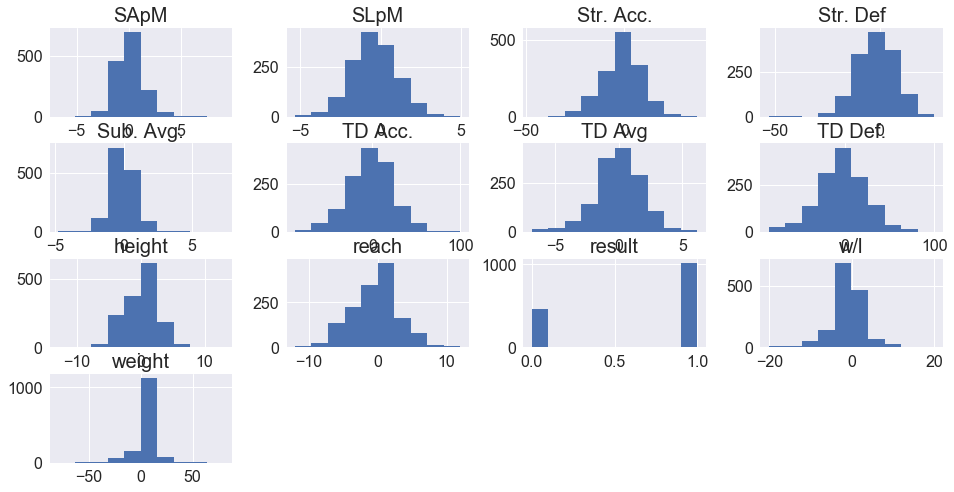

In [175]:
_ = df_deltas_top15.hist()

In [233]:
df_5w[(df_5w['first'] == 'Georges') ]

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
2416,Georges,St-Pierre,Rush,"5' 11""",170 lbs.,"76.0""",Orthodox,25,2,0,n/a,3.77,53%,1.38,72%,4.2,74%,83%,1.1


In [231]:
model = clf.fit(X, y)

In [236]:
#predict Conor vs Nate
conor_stats = df_5w[(df_5w['first'] == 'TJ') & (df_5w['last'] == 'Dillashaw')]
nate_stats = df_5w[(df_5w['first'] == 'Dominick') & (df_5w['last'] == 'Cruz')]
conor_stats['result'] = 'n/a'
nate_stats['result'] = 'n/a'
try_delta = generate_delta(conor_stats, nate_stats).iloc[:,:-1].as_matrix()
model.predict(try_delta)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


array([ 0.])

In [251]:
ones_ratio = sum(y)/len(y)
zeros_ratio = 1-ones_ratio
(ones_ratio*ones_ratio)+(zeros_ratio*zeros_ratio)

0.57307476484815911